# Global Optimization (Differential Evolution)

The following global optimizers are implemented in Optiland:
1. Differential Evolution
2. Dual Annealing
3. SHGO
4. Basin-hopping

These optimizers wrap the scipy.optimize implementations.

In [1]:
import numpy as np
from optiland import optic, optimization

Define a starting lens:

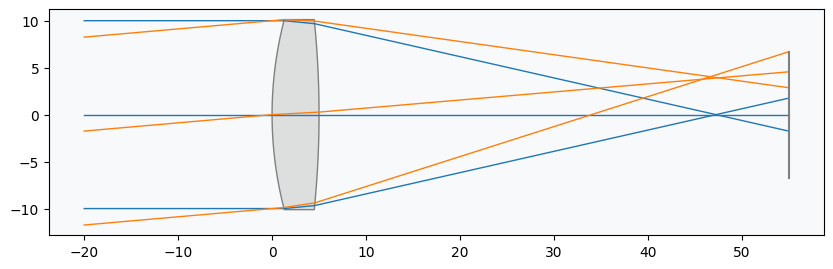

In [2]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=40, thickness=5, material='SK16', is_stop=True)
lens.add_surface(index=2, radius=-100, thickness=50)
lens.add_surface(index=3)

# set aperture
lens.set_aperture(aperture_type='EPD', value=20)

# set fields
lens.set_field_type(field_type='angle')
lens.add_field(y=0)
lens.add_field(y=5)

# set wavelength
lens.add_wavelength(value=0.55, is_primary=True)

lens.draw()

Define optimization problem:

In [3]:
problem = optimization.OptimizationProblem()

Add operands (targets for optimization):

In [4]:
"""
Add a focal length operand and wavefront error operands for all fields.

Use Gaussian quadrature distribution for the rays (see distribution documentation for more information).
"""

# focal length target
input_data = {'optic': lens}
problem.add_operand(operand_type='f2', target=60, weight=1, input_data=input_data)

# wavefront error target
for field in lens.fields.get_field_coords():
    input_data = {'optic': lens, 'Hx':field[0], 'Hy': field[1], 'num_rays': 3, 'wavelength': 0.55, 'distribution': 'gaussian_quad'}
    problem.add_operand(operand_type='OPD_difference', target=0, weight=1, input_data=input_data)

Define variables - let both radii of curvature vary. We will use differential evolution, which requires bounds for all variables.

In [5]:
problem.add_variable(lens, 'radius', surface_number=1, min_val=-500, max_val=500)
problem.add_variable(lens, 'radius', surface_number=2, min_val=-500, max_val=500)

Let thicknesses to image plane vary:

In [6]:
problem.add_variable(lens, 'thickness', surface_number=2, min_val=30, max_val=100)

Check initial merit function value and system properties:

In [7]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                3716.81 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════╤═════════╤══════════╤════════════════════╕
│    │ Operand Type   │   Target │   Weight │   Value │    Delta │   Contribution (%) │
╞════╪════════════════╪══════════╪══════════╪═════════╪══════════╪════════════════════╡
│  0 │ f2             │       60 │        1 │ 46.5275 │ -13.4725 │            4.88345 │
│  1 │ OPD difference │        0 │        1 │ 56.0052 │  56.0052 │           84.3891  │
│  2 │ OPD difference │        0 │        1 │ 19.968  │  19.968  │           10.7275  │
╘════╧════════════════╧══════════╧══════════╧═════════╧══════════╧════════════════════╛
╒════╤═════════════════╤═══════════╤═════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │   Value │ 

Define optimizer:

In [8]:
optimizer = optimization.DifferentialEvolution(problem)

Run optimization:

In [9]:
optimizer.optimize(maxiter=256, disp=False, workers=-1)  # workers=-1 uses all available cores

             message: Optimization terminated successfully.
             success: True
                 fun: 3.612745542781897
                   x: [-5.386e-01 -2.897e+00  4.682e+00]
                 nit: 69
                nfev: 3462
          population: [[-5.386e-01 -2.897e+00  4.682e+00]
                       [-5.320e-01 -2.821e+00  4.705e+00]
                       ...
                       [-5.352e-01 -2.862e+00  4.696e+00]
                       [-5.356e-01 -2.837e+00  4.676e+00]]
 population_energies: [ 3.613e+00  3.772e+00 ...  3.656e+00  3.675e+00]
                 jac: [ 1.009e+03  2.971e+01  4.932e+01]

Print merit function value and system properties after optimization:

In [10]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                3.61275 │           99.9028 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════╤══════════╤══════════╤════════════════════╕
│    │ Operand Type   │   Target │   Weight │    Value │    Delta │   Contribution (%) │
╞════╪════════════════╪══════════╪══════════╪══════════╪══════════╪════════════════════╡
│  0 │ f2             │       60 │        1 │ 60.1043  │ 0.104299 │           0.301108 │
│  1 │ OPD difference │        0 │        1 │  1.30422 │ 1.30422  │          47.0832   │
│  2 │ OPD difference │        0 │        1 │  1.37872 │ 1.37872  │          52.6157   │
╘════╧════════════════╧══════════╧══════════╧══════════╧══════════╧════════════════════╛
╒════╤═════════════════╤═══════════╤═══════════╤══════════════╤══════════════╕
│    │ Variable Type   │   Surface │  

Draw final lens:

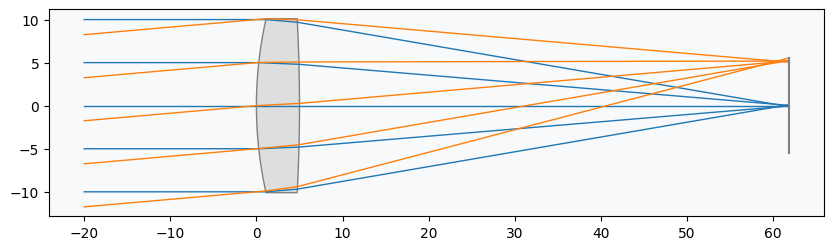

In [11]:
lens.draw(num_rays=5)